# Decision tree classifier: diabetes prediction

Absolutely minimal MVP (minimum viable product) solution.

## 1. Data acquisition

### 1.1. Load

In [1]:
import pandas as pd

# Set random seed for notebook
random_seed=42

# Set train-test split fraction
testing_fraction=0.2

# Set cross-validation folds for experiments
folds=5

# Class weighting for decision trees
class_weights=None

# Load the data from the URL
data_df=pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv")
data_df.drop_duplicates().reset_index(inplace=True, drop=True)

### 1.2. Train-test split

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing
training_df, testing_df=train_test_split(
    data_df,
    test_size=testing_fraction,
    random_state=random_seed
)

# Reset the indexes
training_df.reset_index(inplace=True, drop=True)
testing_df.reset_index(inplace=True, drop=True)

In [3]:
# Get features and labels
training_labels=training_df['Outcome']
training_features=training_df.drop('Outcome', axis=1)

### 1.3. Inspect the data types

In [4]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 38.5 KB


In [5]:
training_labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 614 entries, 0 to 613
Series name: Outcome
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 4.9 KB


In [6]:
list(training_labels[:10])

[0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

## 3. Baseline decision tree classifier

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments={'Baseline': scores * 100}

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 72.0 +/- 5.2%



Model is 100.0% accurate on the training data
Fitted tree depth: 14

Feature importances:
 Pregnancies: 0.032
 Glucose: 0.305
 BloodPressure: 0.136
 SkinThickness: 0.076
 Insulin: 0.061
 BMI: 0.155
 DiabetesPedigreeFunction: 0.115
 Age: 0.120



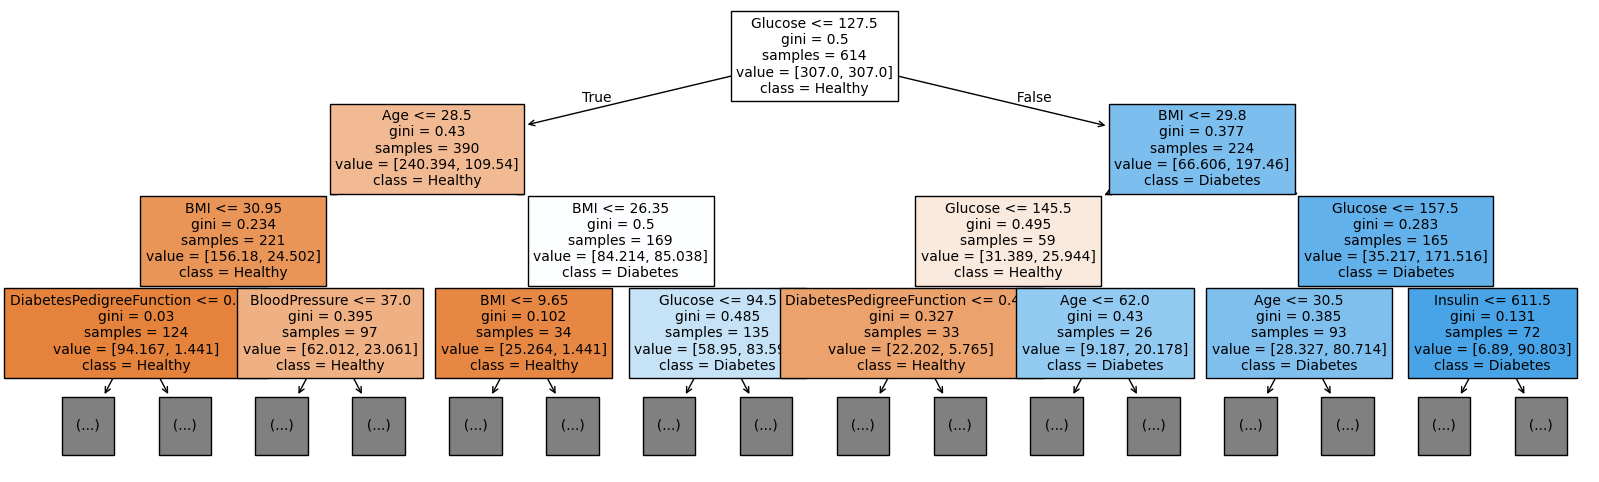

In [8]:
# Let's take a look at the tree
import matplotlib.pyplot as plt
from sklearn import tree

model=DecisionTreeClassifier(random_state=random_seed, class_weight='balanced')
fit_result=model.fit(training_features, training_labels)

# Make predictions from test set features
predicted_labels=model.predict(training_features)

# Score predictions for accuracy
percent_accuracy=accuracy_score(training_labels, predicted_labels) * 100

# Show some details about the model
print(f'\nModel is {percent_accuracy:.1f}% accurate on the training data')
print(f'Fitted tree depth: {fit_result.tree_.max_depth}')
print('\nFeature importances:')

for feature, importance in zip(training_features.columns, fit_result.tree_.compute_feature_importances()):
    print(f' {feature}: {importance:.3f}')

print()

# Plot the first few levels of the tree
fig=plt.figure(figsize=(20,6))

tree.plot_tree(model,
    feature_names=list(training_features.columns),
    class_names=['Healthy', 'Diabetes'],
    filled=True,
    fontsize=10,
    max_depth=3
)

plt.show()

## 2. EDA/feature engineering

### 2.1. Feature distributions

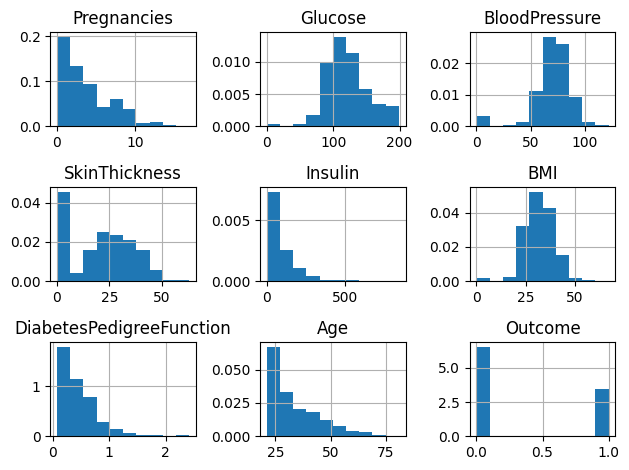

In [9]:
import matplotlib.pyplot as plt

training_df.hist(density=True, layout=(3,3))
plt.tight_layout()
plt.show()

In [10]:
training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,120.855049,69.415309,20.399023,81.438111,31.983388,0.469168,32.907166,0.346906
std,3.313264,32.035057,18.512599,15.433974,116.234835,7.740625,0.336847,11.503437,0.476373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,64.000000,0.000000,0.000000,27.100000,0.241500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000,1.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


First weird thing... we have at least one record where everything except DPF and age is zero - I'm pretty sure that someone didn't have zero blood pressure or zero skin thickness! That's probably missing data. Just how much is there?

In [11]:
dead_people=len(training_df[training_df['BloodPressure'] == 0])
print(f'Have {dead_people} people with a blood pressure of 0')

Have 24 people with a blood pressure of 0


### 2.2. Missing values

Ok, if we were to remove rows that contain zero in one of 'Glucose','BloodPressure','SkinThickness','Insulin','BMI', how much data would we have left?

In [12]:
import numpy as np

# Features to look for zeros in
missing_data_features=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# Remove rows that have at least one zeros, using a copy, in case we decide it's a bad idea
filtered_training_df=training_df.copy()
filtered_training_df[missing_data_features]=filtered_training_df[missing_data_features].replace({0:np.nan})
filtered_training_df.dropna(inplace=True)

filtered_training_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,3.285714,123.046584,70.636646,28.751553,154.940994,32.959938,0.507724,30.534161,0.319876
std,3.155233,30.363750,12.788537,10.459256,119.910375,7.151758,0.344815,9.833841,0.467154
min,0.000000,56.000000,24.000000,10.000000,14.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,100.000000,62.000000,20.000000,78.250000,27.800000,0.267250,23.000000,0.000000
50%,2.000000,119.500000,70.000000,28.500000,121.000000,32.900000,0.441000,27.000000,0.000000
75%,5.000000,142.000000,80.000000,36.000000,183.750000,36.875000,0.652750,35.000000,1.000000
max,17.000000,198.000000,110.000000,63.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Wow, ok - so that's almost half of our data! We can't just throw all of those examples away. Let's try a simple imputation for each feature.

#### 2.2.1. Simple imputation

In [13]:
simple_imputed_training_features=training_features.copy()

for target_feature in missing_data_features:

    impute_data=simple_imputed_training_features[simple_imputed_training_features[target_feature] != 0][target_feature]
    target_feature_imputed_value=impute_data.min()
    imputed_data=simple_imputed_training_features[target_feature].replace({0:target_feature_imputed_value})
    simple_imputed_training_features[target_feature]=imputed_data

    print(f'{target_feature} imputed value: {target_feature_imputed_value:.1f}')

simple_imputed_training_features.describe()

Glucose imputed value: 44.0
BloodPressure imputed value: 24.0
SkinThickness imputed value: 8.0
Insulin imputed value: 14.0
BMI imputed value: 18.2


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,3.742671,121.213355,70.353420,22.692182,88.050489,32.190879,0.469168,32.907166
std,3.313264,30.905662,15.294942,12.554145,111.717100,7.096649,0.336847,11.503437
min,0.000000,44.000000,24.000000,8.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,100.000000,64.000000,8.000000,14.000000,27.100000,0.241500,24.000000
50%,3.000000,117.000000,72.000000,23.000000,42.500000,32.000000,0.372500,29.000000
75%,6.000000,139.000000,80.000000,32.000000,129.750000,36.375000,0.613750,40.000000
max,17.000000,199.000000,122.000000,63.000000,846.000000,67.100000,2.420000,81.000000


Try the cross-validation again and see how we did.

In [14]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    simple_imputed_training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Simple imputation']=scores * 100

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 71.8 +/- 5.0%


Slightly worse than leaving the zeros in. Let's try a little bit more advanced imputation strategy from scikit-learn:

#### 2.2.2. Scikit-learn IterativeImputer

In [15]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
feature_names=training_features.columns

# Make a copy of the training features dataframe, in case we decide that this
# is a bad idea
imputed_training_features=training_features.copy()
imputed_training_features[missing_data_features]=imputed_training_features[missing_data_features].replace({0:np.nan})

# Quantile transform our target features - this is for the imputer, not the decision tree
qt=QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit(imputed_training_features[missing_data_features])
imputed_training_features[missing_data_features]=qt.transform(imputed_training_features[missing_data_features])

# Run the imputation
imp=IterativeImputer(max_iter=100, verbose=True, tol=1e-6)
imp.fit(imputed_training_features)
imputed_training_features=imp.transform(imputed_training_features)

# Convert back to pandas
imputed_training_features=pd.DataFrame(data=imputed_training_features, columns=feature_names)

[IterativeImputer] Completing matrix with shape (614, 8)
[IterativeImputer] Change: 0.8850531789878213, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.08509623059966442, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.04089592715771981, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.023640014648550006, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.013677322837206518, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.007913158618769095, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.00457794178757398, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.0026482928595220057, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.001531939127586035, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.000886135933858806, scaled tolerance: 8.099999999999999e-05 
[IterativeImputer] Change: 0.000512560844257964

In [16]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 72.5 +/- 1.2%


Same mean accuracy as the simple imputation strategy and not any better than baseline. Although, the variability between cross-validation folds did go down a little.

### 2.3. Feature selection

In [17]:
from sklearn.feature_selection import RFECV

min_features_to_select=2
clf=DecisionTreeClassifier(random_state=random_seed)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(7),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

rfecv.fit(training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


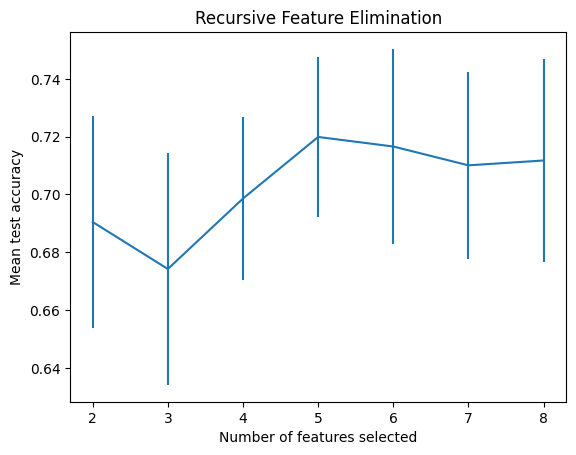

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Mean test accuracy')
plt.errorbar(
    x=cv_results['n_features'],
    y=cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
)
plt.title('Recursive Feature Elimination')
plt.show()

In [19]:
selected_training_features=training_features.to_numpy()
selected_training_features=selected_training_features[:,rfecv.get_support()]

selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
selected_training_features=pd.DataFrame(data=selected_training_features, columns=selected_feature_names)
selected_training_features.head()

,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
0,84.0,0.0,0.0,0.304,21.0
1,112.0,82.0,28.2,1.282,50.0
2,139.0,46.0,28.7,0.654,22.0
3,161.0,50.0,21.9,0.254,65.0
4,134.0,80.0,46.2,0.238,46.0


In [20]:
selected_training_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   614 non-null    float64
 1   BloodPressure             614 non-null    float64
 2   BMI                       614 non-null    float64
 3   DiabetesPedigreeFunction  614 non-null    float64
 4   Age                       614 non-null    float64
dtypes: float64(5)
memory usage: 24.1 KB


In [21]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    selected_training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection']=scores * 100

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.4 +/- 4.4%


### 2.4. Results

Let's take a look at how we are doing so far by plotting the cross-validation results we have so far.

In [22]:
import seaborn as sns

def plot_cross_validation(title: str, results: dict) -> plt:
    '''Takes a list of dictionary of cross validation results
    plots as horizontal box-and-whiskers plot. Returns plot
    object.'''

    sns.boxplot(
        # y = 'Condition',
        # x = results.keys(),
        data = pd.DataFrame.from_dict(results),
        orient = 'h'
    )
    
    plt.title(title)
    plt.xlabel('Accuracy (%)')
    plt.tight_layout()

    return plt

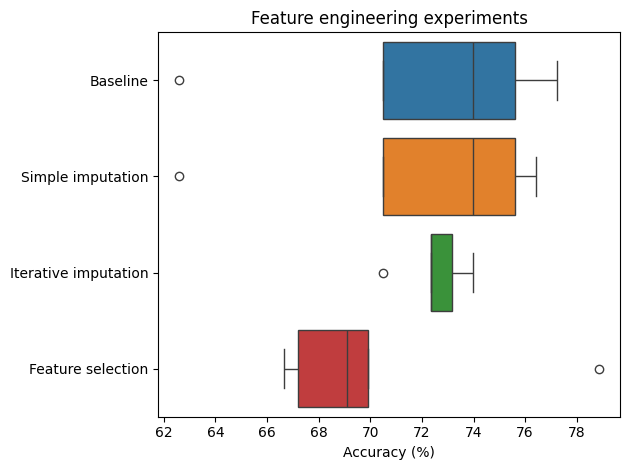

In [23]:
plot_cross_validation('Feature engineering experiments', experiments).show()

### 2.5. Follow-up experiments

Just for fun, let's try some combinations of the above strategies before we move on. For example, what happens if we do imputation and then feature selection?

#### 2.5.1. Impute, then select features

In [24]:
min_features_to_select=1
clf=DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(7),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)

rfecv.fit(imputed_training_features, training_labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


In [25]:
imputed_selected_training_features=imputed_training_features.to_numpy()
imputed_selected_training_features=imputed_selected_training_features[:,rfecv.get_support()]

imputed_selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
imputed_selected_training_features=pd.DataFrame(data=imputed_selected_training_features, columns=imputed_selected_feature_names)
imputed_selected_training_features.head()

,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.101010,0.232703,0.406815,0.304,21.0
1,0.416667,0.390575,0.300000,1.282,50.0
2,0.746032,0.269750,0.323810,0.654,22.0
3,0.871042,0.725229,0.068519,0.254,65.0
4,0.706349,0.906849,0.911478,0.238,46.0


In [26]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_selected_training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Iterative imputation,\nfeature selection']=scores * 100

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.5 +/- 4.3%


#### 2.5.2 Select features, then impute

In [27]:
# First we need a new missing data features list that contains only
# missing data features which were selected by the recursive feature elimination
selected_missing_data_features=[]

for feature in missing_data_features:
    if feature in selected_training_features.columns:
        selected_missing_data_features.append(feature)

# Save the feature names for later - the imputer will return a numpy array
# and we might like to get out Pandas dataframe back
selected_feature_names=selected_training_features.columns

# Make a copy of the training features dataframe, in case we decide that this
# is a bad idea
selected_imputed_training_features=selected_training_features.copy()
selected_imputed_training_features[selected_missing_data_features]=selected_imputed_training_features[selected_missing_data_features].replace({0:np.nan})

# Quantile transform our target features - this is for the imputer, not the decision tree
qt=QuantileTransformer(n_quantiles=10, random_state=0)
qt.fit(selected_imputed_training_features[selected_missing_data_features])
imputed_training_features[selected_missing_data_features]=qt.transform(imputed_training_features[selected_missing_data_features])

# Run the imputation
imp=IterativeImputer(max_iter=100, verbose=True, tol=1e-6)
imp.fit(selected_imputed_training_features)
selected_imputed_training_features=imp.transform(selected_imputed_training_features)

# Convert back to pandas
selected_imputed_training_features=pd.DataFrame(data=selected_imputed_training_features, columns=selected_feature_names)

[IterativeImputer] Completing matrix with shape (614, 5)
[IterativeImputer] Change: 18.213286077473455, scaled tolerance: 0.00019899999999999999 
[IterativeImputer] Change: 1.094530250858945, scaled tolerance: 0.00019899999999999999 
[IterativeImputer] Change: 0.0753064530236145, scaled tolerance: 0.00019899999999999999 
[IterativeImputer] Change: 0.005175476153894465, scaled tolerance: 0.00019899999999999999 
[IterativeImputer] Change: 0.00035568928285556467, scaled tolerance: 0.00019899999999999999 
[IterativeImputer] Change: 2.4445065797351617e-05, scaled tolerance: 0.00019899999999999999 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (614, 5)


In [28]:
# Run cross-validation
scores=cross_val_score(
    DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights),
    imputed_selected_training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
experiments['Feature selection,\niterative imputation']=scores * 100

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 70.5 +/- 4.3%


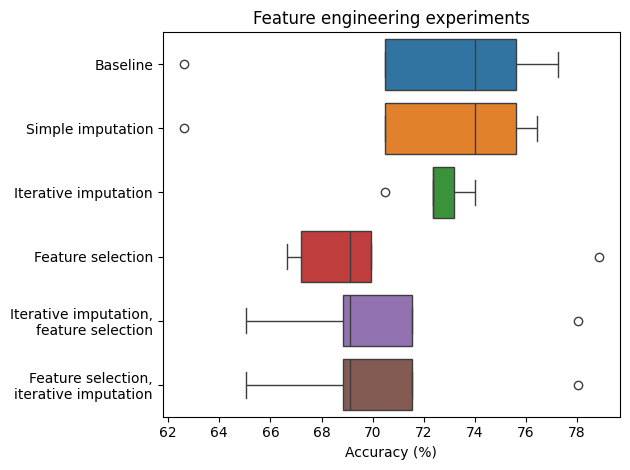

In [29]:
plot_cross_validation('Feature engineering experiments', experiments).show()

## 3. Hyperparameter optimization

In [30]:
# Start new results holder for hyperparameter optimization results
hyperparameter_experiments={
    'Baseline': experiments['Baseline'],
    'Feature selection': experiments['Feature selection']
}

In [31]:
#from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

model=DecisionTreeClassifier(random_state=random_seed, class_weight=class_weights)

distributions={
    # 'criterion': ['gini', 'entropy'],
    # 'splitter': ['best', 'random'],
    'max_depth': list(range(1, 10)),
    'min_samples_split': list(range(10, 50)),
    'min_samples_leaf': list(range(10, 50)),
    # 'min_weight_fraction_leaf': uniform(loc=0, scale=0.5),
    # 'max_features': uniform(loc=0, scale=1),
    # 'min_impurity_decrease': uniform(loc=0, scale=1),
    # 'class_weight': [None, 'balanced']
}

grid=RandomizedSearchCV(
    model,
    distributions,
    scoring='accuracy',
    n_jobs=-1,
    cv=StratifiedKFold(7),
    n_iter=100,
    random_state=random_seed
)

results=grid.fit(selected_training_features, training_labels)
print(f'Best hyperparameters: {results.best_params_}')

Best hyperparameters: {'min_samples_split': 22, 'min_samples_leaf': 12, 'max_depth': 7}


/mnt/arkk/4geeks_repos/gperdrizet-decision-tree-project/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [32]:
# Instantiate a model using the winning parameters
model=DecisionTreeClassifier(
    # class_weight=results.best_params_['class_weight'],
    # criterion=results.best_params_['criterion'],
    max_depth=results.best_params_['max_depth'],
    # max_features=results.best_params_['max_features'],
    # min_impurity_decrease=results.best_params_['min_impurity_decrease'],
    min_samples_leaf=results.best_params_['min_samples_leaf'],
    min_samples_split=results.best_params_['min_samples_split'],
    # min_weight_fraction_leaf=results.best_params_['min_weight_fraction_leaf'],
    # splitter=results.best_params_['splitter'],
    random_state=random_seed,
    class_weight=class_weights
)

# Run cross-validation on the best model
scores=cross_val_score(
    model,
    selected_training_features,
    training_labels,
    cv=StratifiedKFold(folds),
    n_jobs=-1,
    scoring='accuracy'
)

# Collect the scores so we can plot and compare later
hyperparameter_experiments['RandomSearchCV winner,\nselected features']=scores * 100

print(f'Cross-validation accuracy: {(scores.mean() * 100):.1f} +/- {(scores.std() * 100):.1f}%')

Cross-validation accuracy: 76.9 +/- 3.3%


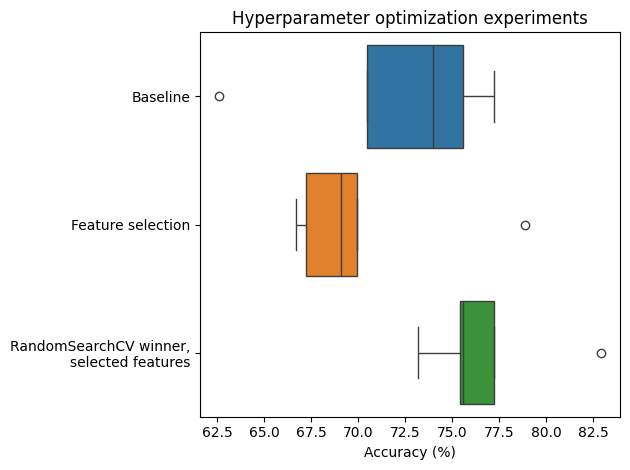

In [33]:
plot_cross_validation('Hyperparameter optimization experiments', hyperparameter_experiments).show()

## 4. Evaluation

In [34]:
# Get features and labels
testing_labels=testing_df['Outcome']
testing_features=testing_df.drop('Outcome', axis=1)

imputed_testing_features=testing_features.copy()
imputed_testing_features[missing_data_features]=imputed_testing_features[missing_data_features].replace({0:np.nan})

imputed_testing_features[missing_data_features]=qt.transform(imputed_testing_features[missing_data_features])
imputed_testing_features=imp.transform(imputed_testing_features)

# Convert back to pandas
imputed_testing_features=pd.DataFrame(data=imputed_testing_features, columns=feature_names)
imputed_testing_features.describe()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Insulin
- SkinThickness


In [ ]:
imputed_testing_features=imputed_testing_features.to_numpy()
selected_imputed_testing_features=imputed_testing_features[:,rfecv.get_support()]

selected_feature_names=[b for a, b in zip(rfecv.get_support(), feature_names) if a]
selected_imputed_testing_features=pd.DataFrame(data=selected_imputed_testing_features, columns=selected_feature_names)
selected_imputed_testing_features.head()

In [ ]:
# Make predictions from test set features
predicted_labels=model.predict(selected_imputed_testing_features)

# Score predictions from accuracy
percent_accuracy=accuracy_score(testing_labels, predicted_labels) * 100
print(f'Model is {percent_accuracy:.1f}% accurate on the test data')